### Находим оптимальные режимы для пушки

https://www.youtube.com/watch?v=pQIXIpz-gu4



In [1]:
from ipyparallel import Client
cl = Client()
lbv = cl.load_balanced_view()
print(f'Запущено {len(lbv)} ядер')

Запущено 10 ядер


In [2]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [3]:
cl[:]['wd'] = wd

In [4]:
%%px --local
print(wd)

D:\pyKas
[stdout:0] D:\pyKas
[stdout:1] D:\pyKas
[stdout:2] D:\pyKas
[stdout:3] D:\pyKas
[stdout:4] D:\pyKas
[stdout:5] D:\pyKas
[stdout:6] D:\pyKas
[stdout:7] D:\pyKas
[stdout:8] D:\pyKas
[stdout:9] D:\pyKas


In [5]:
%%px
import os
import sys
sys.path.append(wd+"\\src\\")

In [6]:
%%px --local
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [7]:
%%px --local
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [8]:
%%px --local
import json
from functional import seq

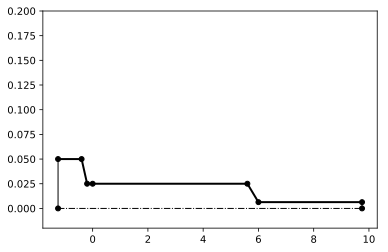

In [9]:
def get_tube(**kw):
    D_1 = kw.get('D_1', 100e-3)
    D_2 = kw.get('D_2', 50e-3)
    D_3 = kw.get('D_3', 12.7e-3)
    V_1 = kw.get('V_1', 8)/1000
    tube_dict = {
        'tube_points': [[-10*D_1,D_1],[-D_1*4, D_1],[-D_1*2,D_2],[0, D_2], [5.6, D_2], [5.6+0.4, D_3], [5.6+0.4+3.75, D_3]]
    }
    tube = Tube.get_standart(tube_dict)
    x_1 = tube.get_x1(0, V_1)
    tube_dict['tube_points'][0][0] = x_1
    tube = Tube.get_standart(tube_dict)
    return tube

tube = get_tube()
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.02, 2*0.1)
# fig.set_xlim(-6*d,d)
plt.show()

In [18]:
class AP_Sandwich(object):
    @classmethod
    def get_sandw(cls, **kwargs):
        tube = get_tube(**kwargs)
        res = cls(tube)
        gas_layer_dict1 = {
            'type': 'gas',
            'name': 'Air',
            'gamma': 1.4,
            'kappa': 0.0010838,
            'R': 287,
            'T_0': 300,
            'p_0': kwargs.get('P_1', 30)*1e6, # начальное давление газа
            'u_0': 0,     #начальная скорость
            'x_2': 0
        }
        n_cells_1 = kwargs.get('n_cells_1', 200)
        index_anchor = n_cells_1//2
        calc_settings1 = {
            'n_cells': n_cells_1,
            'GasFluxCalculator_kwargs': {'flux_type':2, 'x_order':1},
            'GridStrecher_kwargs': {'strech_type': 1, 'index_anchor':index_anchor}
        }
        gl = GasLayer.get_standart(tube, tube.get_xs()[0], gas_layer_dict1, calc_settings1)
        res.layers.append(gl)
        
        pist_omega = kwargs.get('pist_omega', 200)/1000
        pist_layer_dict = {
            'type': 'pist',
            'omega': pist_omega,  # кг
            'p_0': kwargs.get('P_2', 1e-1)*1e6, # начальное давление в полиэтилене
            'u_0': 0,     #начальная скорость
            'ElPistEOS_kwargs': dict(
                k=1.63098, 
                c_0=2308, 
                ro_0=919.03, 
                sigma_star=25.2, 
                k_0=0.054, 
                b_1=0.027, 
                b_2=0.00675, 
                tau_0=1.36, 
                mu=0.001, 
                tau_s=1,                 
                zeroP=False, 
                zeroE=True)
        }
        calc_settings_pist = {
            'cell_dx': 0.001,
        #     'n_cells': 600,
            'n_cells_min': 13,
            'n_cells_max': 100,
            'GasFluxCalculator_kwargs': {'flux_type':1},
            'GridStrecher_kwargs': {}
        }
        pist_lr = ElPistLayer.get_standart(tube, 0, pist_layer_dict, calc_settings_pist) 
        res.layers.append(pist_lr)
   
        gas_layer_dict2 = {
            'type': 'gas',
            'T_0': 300,
            'p_0': kwargs.get('P_2', 0.1)*1e6, # начальное давление газа
            'u_0': 0,     #начальная скорость
            'x_2': kwargs.get('x_elem', 6000)/1000
        }
        gas_type2 = kwargs.get('gas_type2', 'He')
        if gas_type2 == 'He':
            gas_layer_dict2['name'] = 'He'
            gas_layer_dict2['gamma'] = 1.66
            gas_layer_dict2['kappa'] = 0.005925
            gas_layer_dict2['R'] = 2078
        elif gas_type2 == 'H2':
            gas_layer_dict2['name'] = 'H2'
            gas_layer_dict2['gamma'] = 1.4
            gas_layer_dict2['kappa'] = 0 # 0.005925
            gas_layer_dict2['R'] = 4125
        calc_settings2 = {
            'cell_dx': 0.01,
        #     'n_cells': 600,
            'n_cells_min': 100,
            'n_cells_max': 500,
            'GasFluxCalculator_kwargs': {'flux_type':2},
            'GridStrecher_kwargs': {}
        }
        gl2 = GasLayer.get_standart(tube, pist_lr.xs_borders[-1], gas_layer_dict2, calc_settings2)
        res.layers.append(gl2)
        q = kwargs.get('q', 2)/1000
        p_f = kwargs.get('p_f', 100)*1e6
        res.border = BorderSimple(gl2, None, q, p_f)
        
        return res
        
                                     
    def __init__(self, tube: Tube, i=0):
        self.tube = tube
        self.i = i
        self.layers = []
        self.border = None
    
    def connect_borders_layers(self):
        if len(self.layers)+1 != len(self.borders):
            raise AttributeError(f'Неправильное количество границ и слоев len(self.layers)={len(self.layers)}  len(self.borders)={len(self.borders)}')
        all_layers = [None] + self.layers + [None]
        for b, lr_left, lr_right in zip(self.borders, all_layers[:-1], all_layers[1:]):
            b.lr_left = lr_left
            b.lr_right = lr_right
        
    def simple_step(self, courant):
        tau = min([lr.get_tau_min() for lr in self.layers]) * courant
        self.border.update_xs()
        self.border.update_Vs(tau)
        result = AP_Sandwich(self.tube, self.i+1)
        
        pl = self.layers[0].ps[-1]
        pr = self.layers[-1].ps[0]
        u1, u2 = self.layers[1].flux_calculator.get_Vs_border_svobodn(self.layers[1], p_left=pl, p_right=pr)
        result.layers.append(self.layers[0].step_simple(tau, 0, u1))
        result.layers.append(self.layers[1].step_simple(tau, u1, u2))
        result.layers.append(self.layers[2].step_simple(tau, u2, self.layers[2].Vs_borders[-1]))
        
        result.border = self.border.copy()
        result.border.lr_left = result.layers[-1]
        return result
#         tau = min([lr.get_tau_min() for lr in self.layers]) * courant
#         for b in self.borders:
#             b.update_xs()
#         for b in self.borders:
#             b.update_Vs(tau)
#         result = AP_Sandwich(self.tube, self.i+1)
#         result.layers = [lr.step_up(tau) for lr in self.layers]
#         result.borders= [b.copy() for b in self.borders]
#         result.connect_borders_layers()
#         return result
    
    def plot(self, fig, ax, **kwargs):
        self.tube.plot(fig, ax, **kwargs)
        for lr in self.layers:
            lr.plot(fig, ax, **kwargs)
            
    def plot_param(self, fig, ax, param_name, **kwargs):
        for lr in self.layers:
            xs = np.array(lr.xs_cells)
            ys = np.array(getattr(lr, param_name))
            color = lr.color_4_plot
            lw = kwargs.get('lw', 2)
            ax.plot(xs, ys, color=color, lw=lw)
            
    def get_t(self):
        ts = [lr.time for lr in self.layers]
        if abs(min(ts) - max(ts)) > 1e-14:
            print(f'Слои не синхронизированны {ts}')
        return ts[0]
    
    def get_vel(self):
        return self.layers[-1].Vs_borders[-1]
    
    def get_x_projectile(self):
        return self.layers[-1].xs_borders[-1]

    
    def get_p_max(self):
        return max([np.max(lr.ps) for lr in self.layers])
    
    def __str__(self):
        res = f'Sandwich i={self.i}; t={self.get_t()*1000} ms;  vel={self.get_vel()} m/s;  p_max={self.get_p_max()*1e-6} MPa\nlayers:\n'
        for i, lr in enumerate(self.layers):
            res += f'{i}) {lr}\n'
        return res
    
    def __repr__(self):
        return str(self)
    
    def get_E_sum(self):
        e = sum([lr.get_E_sum() for lr in self.layers])
        e += self.border.get_v0()**2*self.border.mass/2 
        return e

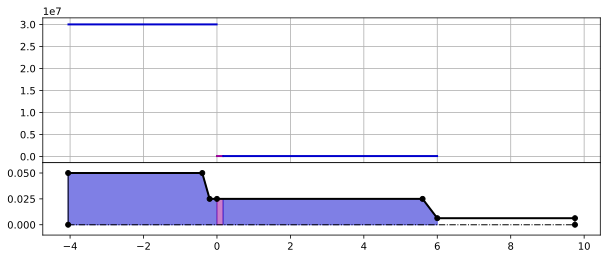

Sandwich i=0; t=0.0 ms;  vel=0.0 m/s;  p_max=30.0 MPa
layers:
0) GasLayer(n_cells=200); 
        {'p_max':30000000.0, 'tau_min': 4.2369543288110463e-05, 
        'u_max': 0.0, 'cs_max': 478.2978117061867, 'dx_min': 0.020265259837693783, 
        'x_1': -4.053051967538863, 'x_2': 0.0,
        'V_1':  0.0, 'V_2':  0.0  }
1) ElPistLayer(n_cells=100); 
        {'p_max':100000.0, 'tau_min': 7.203086623633692e-07, 
        'u_max': 0.0, 'cs_max': 2308.0384458555504, 'dx_min': 0.001662500085617441, 
        'x_1': 0.0, 'x_2': 0.16625000856174665,
        'V_1':  0.0, 'V_2':  0.0  }
2) GasLayer(n_cells=500); 
        {'p_max':100000.0, 'tau_min': 8.864233492608827e-06, 
        'u_max': 0.0, 'cs_max': 1316.2446581088182, 'dx_min': 0.01166749998287564, 
        'x_1': 0.16625000856174665, 'x_2': 6.0,
        'V_1':  0.0, 'V_2':  0.0  }

In [34]:
sandw =AP_Sandwich.get_sandw(V_1=30, p_f=30, q=1, P_2=0.1, pist_omega=300, gas_type2='H2')

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10,4), gridspec_kw={'height_ratios':[2, 1]})
sandw.plot_param(fig, ax1, 'ps')
sandw.plot(fig, ax2)
ax2.set_ylim(-0.01,0.06)
# ax2.set_xlim(100*d-0.1,100*d+0.1)
ax1.grid(True)
plt.subplots_adjust(hspace=.0)

plt.show()

sandw

In [35]:
history = [sandw]

In [38]:
for i in tqdm_notebook(range(130000)):
    if sandw.get_x_projectile() > sandw.tube.get_x_right():
        break
    sandw = sandw.simple_step(0.4)
    if i>0 and i % 100 == 0:
        history.append(sandw)
    else:
        history[-1] = sandw

In [46]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(history)-1,step=1, value=len(history)-1))
def plotMe(ind):
    sandw = history[ind]
    fig, (ax0, ax1, ax11, ax2) = plt.subplots(nrows=4, sharex=True, figsize=(10,8), gridspec_kw={'height_ratios':[2, 2, 2, 1]})
    sandw.plot_param(fig, ax1, 'ps')
    ax11.plot(sandw.layers[0].xs_cells, sandw.layers[0].get_Ts(287))
    ax11.plot(sandw.layers[-1].xs_cells, sandw.layers[-1].get_Ts(4125))
    ax1.set_ylim(-10)
    sandw.plot(fig, ax2)
    sandw.plot_param(fig, ax0, 'us')
    ax2.set_ylim(-0.01,0.06)
#     ax0.set_xlim(2,2.5)
    ax1.grid(True)
    ax0.grid(True)
    ax11.grid(True)
    plt.subplots_adjust(hspace=.0)

    plt.show()
    print(sandw)

interactive(children=(IntSlider(value=692, description='ind', max=692), Output()), _dom_classes=('widget-inter…

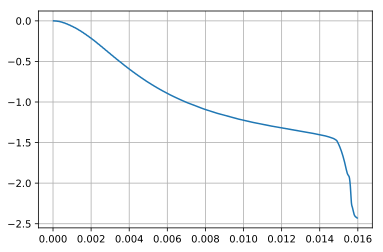

In [47]:
ts = [s.layers[0].time for s in history]
e0 = history[0].get_E_sum()
es = [(s.get_E_sum()-e0)/e0*100 for s in history]
plt.plot(ts, es)
plt.grid()
plt.show()

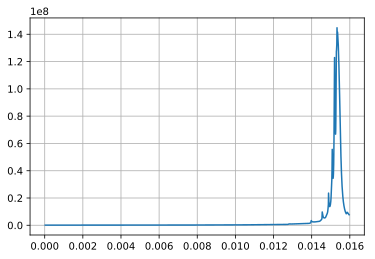

In [48]:
ts = [s.layers[0].time for s in history]
es = [s.layers[-1].ps[-1] for s in history]
plt.plot(ts, es)
plt.grid()
plt.show()